# Indentifying spam in YouTube video comments using RNNs

Tout les jours des centaines de milliers de commentaires sont déposés sur YouTube, certains sont de réels commentaires et d'autres sont des publicités déposés par des bots. 

Il n'est pas réaliste de penser que des humains puissent modérer autant de commentaires.

Des modèles de machines learning sont entraîner pour modérer automatiquement ces commentaires. 

Dans ce notebook, vous allez devoir entraîner un modèle de classificaiton de spam pour résoudre ce problème.

# Importation des packages

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GRU, Dense, Embedding
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1RwEnJX3JHL1-VGvKTuZKAQWMlZ9EbR5o?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
comments_df_list = []
comments_file = ['drive/MyDrive/Data_YouTube/Youtube01-Psy.csv',
                 'drive/MyDrive/Data_YouTube/Youtube02-KatyPerry.csv',
                 'drive/MyDrive/Data_YouTube/Youtube03-LMFAO.csv',
                 'drive/MyDrive/Data_YouTube/Youtube04-Eminem.csv',
                 'drive/MyDrive/Data_YouTube/Youtube05-Shakira.csv']
for f in comments_file:
    df = pd.read_csv(f,header=0)
    comments_df_list.append(df)
comments_df = pd.concat(comments_df_list)
comments_df = comments_df.sample(frac=1.0, random_state=123)
print(comments_df.shape)
comments_df = comments_df.reset_index(drop=True)
comments_df.head(5)

(1956, 5)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z13wf3fztpfffjoit04chjaxhkurtf1oh5g,witsnow roxiie,2014-11-07T20:45:32,We pray for you Little Psy ♡﻿,0
1,z13ew5agxpmnifz3223ljn1rtvidtj0fp,snsddien,2015-05-27T13:17:02.665000,This awesome song needed 4 years to reach to 8...,0
2,z13sgp25fzybg11lc23bhncaipqvgz14q04,Fill Reseni,2015-05-27T17:10:53.724000,The rap: cool Rihanna: STTUUPID﻿,0
3,_2viQ_Qnc69WextJrbKBgZtDWQiRWlkxS317fouQMYc,Chris Boatsome,2013-08-30T22:41:51.117000,Hey dickwad - we&#39;re all africans. The colo...,1
4,z13asbvq1n2ttvptn23vd1mpsmnju5n0o,GALAXIAN HD,2015-04-26T17:36:25.815000,i am from Brazil please subscribe my channel l...,1


In [ ]:
comments_df['CONTENT'] = comments_df['CONTENT'].apply(lambda x : x.replace('\ufeff', ''))
comments_df['CONTENT'] = comments_df['CONTENT'].apply(lambda x : x.replace('\xa0', ''))
comments_df['CONTENT'] = comments_df['CONTENT'].apply(lambda x : x.replace('&#39;', ' '))

In [ ]:
comments_df.loc[1, 'CONTENT']

'This awesome song needed 4 years to reach to 800 mil views while Tango Switch bitch needed 1 year. its not fairrrrrrr'

# Exploration du jeu de données

Visualiser le nombre de spam et le nombre de commentaire réel avec un barplot.

N'hésitez pas à vous aider de la [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html#examples-using-matplotlib-pyplot-bar).

In [ ]:
print("Nombre de commentaires réels : {}".format(np.sum(comments_df['CLASS']==0)))
print("Nombre de spams : {} ".format(np.sum(comments_df['CLASS']==1)))

Nombre de commentaires réels : 951
Nombre de spams : 1005 


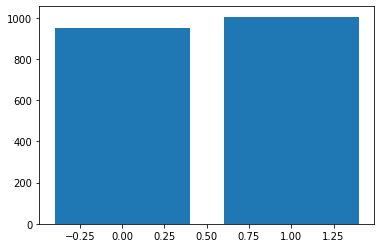

In [ ]:
plt.bar([0, 1], 
        [np.sum(comments_df['CLASS']==0),
        np.sum(comments_df['CLASS']==1)])

plt.show()

Calculez le nombre de mots maximum dans un commentaire.

In [ ]:
max_length = len(np.max(comments_df.CONTENT))
print("Taille du commentaire le plus long : {}".format(max_length))

Taille du commentaire le plus long : 152


Calculez le nombre de mots moyen dans un commentaire.

In [ ]:
average_size = int(sum([len(c) for c in comments_df.CONTENT])/comments_df.shape[0])
print("Taille Moyenne d'un commentaire : {} ".format(average_size))

Taille Moyenne d'un commentaire : 93 


# Prétraitement des données 

Hyperparamètres

In [ ]:
oov_token = "<UNK>"
truncating = 'post'
padding = 'post'

Initialiser le tokenizer. 

Utilisez en paramètre *oov_token=oovtoken*

N'hésitez pas à checker la [doc](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer). 

N'hésitez pas à lire cette [réponse](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do) de stack overflow pour comprendre ce que fait réellement *Tokenizer*.

In [ ]:
tokenizer = Tokenizer(oov_token=oov_token)

Entraîner le texte sur le texte en utilisant la fonction *fit_on_texts*.

N'hésitez pas à lire la [doc](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#fit_on_texts).

In [ ]:
tokenizer.fit_on_texts(comments_df.CONTENT)

Visualiser le dictionnaire de mapping d'un mots à sont identifiant créer durant l'entraînement.

Utilisez l'attribut *word_index*.

In [ ]:
word_index = tokenizer.word_index

Calculer le nombre maximum de mots dans notre corpus.

In [ ]:
vocab_size = len(tokenizer.word_index)
print(vocab_size)

4693


Appliquer la transformation sur nos données en utilisant la fonction *texts_to_sequences*.

N'hésitez pas à lire la [doc](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences).

In [ ]:
x = tokenizer.texts_to_sequences(comments_df.CONTENT)

Comme vous pouvez le voir ci-dessous, toutes les séquences n'ont pas les mêmes longueurs. 

In [ ]:
print("Longueur du premier commentaire : {}".format(len(x[0])))
print("Longueur du deuxième commentaire : {}".format(len(x[1])))

Longueur du premier commentaire : 7
Longueur du deuxième commentaire : 22


Pourtant votre réseau de neurone à besoin d'une taille de séquences fixe pour s'entraîner. 

Il va falloir ajouter des caractères à la fin des plus petits commentaires pour obtenir une même taille pour tous. 

Ce procédé ce nomme padding. 

Utilisez la fonction *pad_sequences* sur vos données.

Dans les hyperparamètres utiliser :
- *padding = padding*
- *truncating=truncating*

N'hésitez pas à lire la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).

In [ ]:
x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=max_length, padding=padding, truncating=truncating)

Visualiser la dimension de la mtrice que vosu avez obtenu.

In [ ]:
x.shape

(1956, 152)

Visualisons l'exemple 1 après les pré traitements.

In [ ]:
x[1]

array([   3,  141,   18,  766,  272,  175,    6,  300,    6,  932, 1812,
         46,  326, 1813, 1814,  933,  766,   58,  157,  138,   70, 1815,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

Visualisons l'exemple 1 avant l'entraînement.

In [ ]:
comments_df.loc[1, 'CONTENT']

'This awesome song needed 4 years to reach to 800 mil views while Tango Switch bitch needed 1 year. its not fairrrrrrr'

Vérifions la correspondance entre le mot et son indice.

In [ ]:
word_index['awesome']

141

A quelle classe appartient cette phrase ?

In [ ]:
comments_df.loc[1, 'CLASS']

0

# Initialisation du modèle 

Hyperparamètres

In [ ]:
embedding_dim = 100

tf.keras.utils.set_random_seed(123)

En utilisant le séquentiel ([doc](https://keras.io/guides/sequential_model/)), initialiser un modèle d'apprentissage profond avec :
- une couche d'embdedding ([doc](https://keras.io/api/layers/core_layers/embedding/)) (input_dim=vocab_size+1, output_dim=embedding_dim, input_length=max_length)
- GRU ([doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)) (unités=64)
- Dense avec pour fonction d'activation la sigmoid ([doc](https://keras.io/api/layers/core_layers/dense/)) (unités=1)

In [ ]:
model = Sequential([
    Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    GRU(units=average_size),
    Dense(1, activation='sigmoid')
])

Compile 

In [ ]:
model.compile(loss=BinaryCrossentropy(),optimizer=Adam(learning_rate=0.1),metrics=['accuracy'])

Summary

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 152, 100)          469400    
                                                                 
 gru_12 (GRU)                (None, 93)                54405     
                                                                 
 dense_12 (Dense)            (None, 1)                 94        
                                                                 
Total params: 523,899
Trainable params: 523,899
Non-trainable params: 0
_________________________________________________________________


# Entraînez votre modèle 

Hyperparamètres 

In [ ]:
num_epochs = 200

Séparer vos données en deux jeux, l'entraînement et le test. 

Utilise zla fonction *train_test_split* de Sklearn.

N'hésitez pas à consulter la [doc](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, comments_df['CLASS'])

Paramètrage des *callbacks*.

In [ ]:
def scheduler(epoch, lr):
  if epoch < 100 :
    return lr
  elif epoch == 100 :
    return lr * 0.1
  else :
    return lr * np.power(0.99,(epoch / 400))

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Entraîner votre modèle sur les données x_train et y_test. 

Utiliser :
- données x_test et y_test en validation. 
- un batch_size de 256
- un nombre d'epochs égale à num_epochs



In [ ]:
history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, y_test),
                    epochs=num_epochs, 
                    batch_size = 256,
                    verbose=1, 
                    callbacks=[callback])
  
print("Training Complete")

Epoch 1/200
6/6 [==============================] - 3s 163ms/step - loss: 1.2275 - accuracy: 0.4969 - val_loss: 0.8839 - val_accuracy: 0.5583 - lr: 0.1000
Epoch 2/200
6/6 [==============================] - 0s 64ms/step - loss: 0.8814 - accuracy: 0.5031 - val_loss: 0.6855 - val_accuracy: 0.5890 - lr: 0.1000
Epoch 3/200
6/6 [==============================] - 0s 65ms/step - loss: 0.8062 - accuracy: 0.5474 - val_loss: 1.0020 - val_accuracy: 0.5112 - lr: 0.1000
Epoch 4/200
6/6 [==============================] - 0s 66ms/step - loss: 1.0433 - accuracy: 0.4983 - val_loss: 1.0659 - val_accuracy: 0.4888 - lr: 0.1000
Epoch 5/200
6/6 [==============================] - 0s 65ms/step - loss: 0.8177 - accuracy: 0.6080 - val_loss: 0.8801 - val_accuracy: 0.5010 - lr: 0.1000
Epoch 6/200
6/6 [==============================] - 0s 64ms/step - loss: 0.7039 - accuracy: 0.6299 - val_loss: 0.8717 - val_accuracy: 0.5849 - lr: 0.1000
Epoch 7/200
6/6 [==============================] - 0s 66ms/step - loss: 0.5741 - 

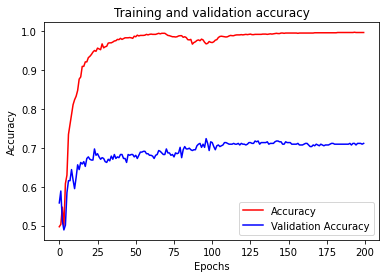

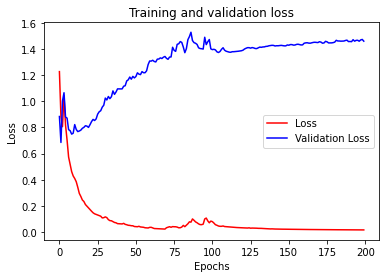

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=model.history.history['accuracy']
val_acc=model.history.history['val_accuracy']
loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

# Entraînement en utilisant un pré-entraînement glove

## Initialisation du modèle

Hyperparamètres 

In [ ]:
num_epochs = 200
embedding_dim = 100

Création de la matrice d'embedding 

In [ ]:
embeddings_index = {};

with open('/content/drive/MyDrive/RNN_sentiment_dataset/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

Initialisation du modèle

In [ ]:
tf.keras.utils.set_random_seed(123)
model_emb = Sequential([
                        Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
                        GRU(units=average_size),
                        Dense(1, activation='sigmoid')
])

Compilation du modèle 

In [ ]:
model_emb.compile(loss=BinaryCrossentropy(),optimizer=Adam(learning_rate=0.1),metrics=['accuracy'])

Summary du modèle

In [ ]:
model_emb.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 152, 100)          469400    
                                                                 
 gru_13 (GRU)                (None, 93)                54405     
                                                                 
 dense_13 (Dense)            (None, 1)                 94        
                                                                 
Total params: 523,899
Trainable params: 54,499
Non-trainable params: 469,400
_________________________________________________________________


Entraînement du modèle

In [ ]:
history = model_emb.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, y_test),
                    epochs=num_epochs, 
                    batch_size = 256,
                    verbose=1, 
                    callbacks=[callback])
  
print("Training Complete")

Epoch 1/200
6/6 [==============================] - 3s 160ms/step - loss: 0.9165 - accuracy: 0.5044 - val_loss: 0.6909 - val_accuracy: 0.5583 - lr: 0.1000
Epoch 2/200
6/6 [==============================] - 0s 61ms/step - loss: 0.7903 - accuracy: 0.5249 - val_loss: 0.7001 - val_accuracy: 0.5583 - lr: 0.1000
Epoch 3/200
6/6 [==============================] - 0s 61ms/step - loss: 0.6942 - accuracy: 0.5944 - val_loss: 0.6881 - val_accuracy: 0.6483 - lr: 0.1000
Epoch 4/200
6/6 [==============================] - 0s 60ms/step - loss: 0.6861 - accuracy: 0.6278 - val_loss: 0.6441 - val_accuracy: 0.6748 - lr: 0.1000
Epoch 5/200
6/6 [==============================] - 0s 62ms/step - loss: 0.6407 - accuracy: 0.6517 - val_loss: 0.6146 - val_accuracy: 0.6646 - lr: 0.1000
Epoch 6/200
6/6 [==============================] - 0s 66ms/step - loss: 0.5981 - accuracy: 0.6796 - val_loss: 0.5902 - val_accuracy: 0.6851 - lr: 0.1000
Epoch 7/200
6/6 [==============================] - 0s 61ms/step - loss: 0.5646 - 

Visualisation des courbes d'entraînements

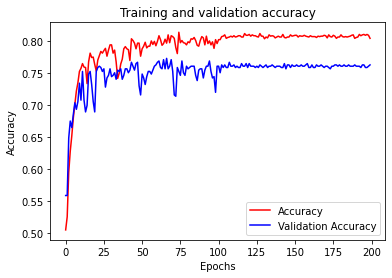

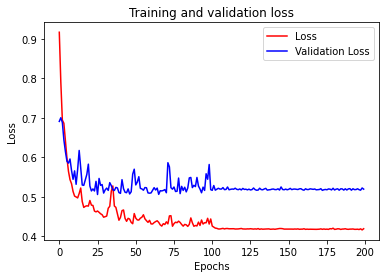

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_emb=model_emb.history.history['accuracy']
val_acc_emb=model_emb.history.history['val_accuracy']
loss_emb=model_emb.history.history['loss']
val_loss_emb=model_emb.history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc_emb, 'r')
plt.plot(epochs, val_acc_emb, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss_emb, 'r')
plt.plot(epochs, val_loss_emb, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.show()

# Comparaison des deux modèles

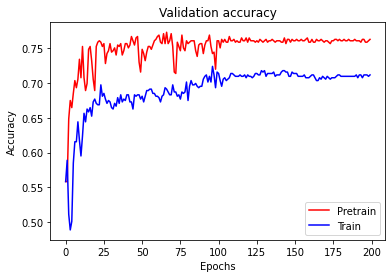

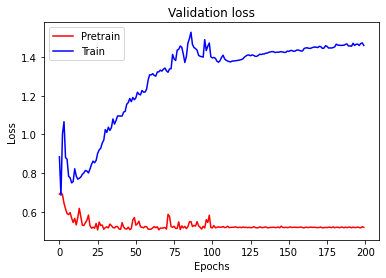

In [ ]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, val_acc_emb, 'r', label='Pretrain')
plt.plot(epochs, val_acc, 'b', label='Train')
plt.title('Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, val_loss_emb, 'r', label='Pretrain')
plt.plot(epochs, val_loss, 'b', label='Train')
plt.title('Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()